In [1]:
# Trajectory code in two point mass gravity, co-rotating frame

In [2]:
import matplotlib.pylab as plt
import numpy as np

from astropy import units as u
from astropy import constants as c

%matplotlib inline

## Constants

In [9]:
# cgs units
solMass = 1.9819E33
jupMass = 1.8986E30
G       = 6.67259E-8
AU      = 1.496E13

## System Parameters

In [19]:
M1 = 1.35*solMass
M2 = 1.41*jupMass

# COM at origin
a0    = 0.0229*AU # binary separation
M1r0  = np.array([a0 * M2/(M1 + M2), 0, 0], dtype=object) # mass 1 coordinates
M2r0  = np.array([a0 * -M1/(M1 + M2), 0, 0], dtype=object) # mass 2 coordinates
Omega = np.array([0, 0, (G*(M1 + M2))**0.5 / a0**1.5], dtype=object) # system angular velocity

## Calculate vel and accel

In [20]:
def sho_func(t, uin): # calculates derivatives for RK4
    # position and velocity
    r = uin[:3]
    v = uin[3:]
    
    # distance of point mass from each M
    d1 = np.linalg.norm(M1r0 - r)
    d2 = np.linalg.norm(M2r0 - r)

    # calulating accelerations
    g_ctrfg = (np.linalg.norm(Omega)**2) * r
    g_cor   = -2 * np.cross(Omega, v)
    g1      = (G*M1/d1**3) * (M1r0 - r)
    g2      = (G*M2/d2**3) * (M2r0 - r)
    
    derivs = np.ndarray(6)
    derivs[:3] = v
    derivs[3:] = g1 + g2 + g_ctrfg + g_cor
    
    return derivs

## L1 Finder

In [15]:
def sho_L1(M1x0, M2x0, tol): #finds L1 to tolerance in net accel. M1 on negative x-axis, M2 on pos
    udum  = np.ndarray(6)
    
    udum[0]  = (M1x0 + M2x0)/2 # first test cut 
    dummy    = sho_func(0.0, udum) # finds acceleration at test cut
    acc      = dummy[3] # holds the acceleration
    up       = M1x0
    down     = M2x0
    
    n = 0
    while (np.abs(acc) > tol):
        if (acc < 0.0):
            down = udum[0]
            udum[0] = (up + udum[0])/2 # moves cut over half
        else:
            up = udum[0]
            udum[0] = (down + udum[0])/2 # moves the other way
        dummy = sho_func(0.0, udum)
        acc   = dummy[3]
        
        n = n+1

        if(n > 200):
            break # just in case
            
    L1 = udum[0]
    
    return L1

## Integrator

In [16]:
def sho_RK4(t, u_old):
    K1 = sho_func(t, u_old)
    K2 = sho_func(t + dt/2, u_old + K1*dt/2)
    K3 = sho_func(t + dt/2, u_old + K2*dt/2)
    K4 = sho_func(t + dt, u_old + K3*dt)
    
    u_new = u_old + (dt/6)*(K1 + 2*(K2 + K3) + K4)
    return u_new

## Program

In [33]:
# Initial conditions
b1 = sho_L1(M1r0[0], M2r0[0], 1E-9)
vorb = np.sqrt(G * M1 / AU) 

x = -b1
y = -0.1
z = 0

vx = 790740.63049190654  #vorb * np.sqrt(2)/2
vy = 0.0
vz = 0.0

pos_0 = np.array([x, y, z])
vel_0 = np.array([vx, vy, vz])

uold = np.ndarray(6)
uold[:3] = pos_0
uold[3:] = vel_0

T = 94452.008132351519/10 #2 * np.pi / np.linalg.norm(Omega) # orbital period
tmax  =  3*T

dt = tmax/6000 

x = []
y = []
x.append(uold[0])
y.append(uold[1])

for t in np.arange(0, tmax+dt, dt):
    unew = sho_RK4(t, uold)
        
    x.append(unew[0])
    y.append(unew[1])
    
    uold = unew # step forward

## XY Plot

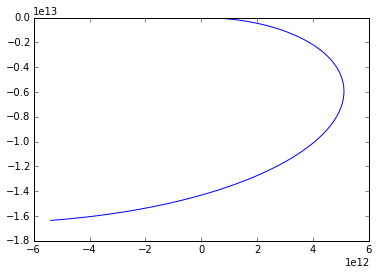

In [34]:
plt.plot(x, y)

In [32]:
b1

342428453.54559457